In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import (split_train_test, 
                                                        logistic_regression_multiclass, 
                                                        f1_score_over_time_multiclass,
                                                        plot_f1_score_over_time,
                                                        create_f1_score_dataframe,
                                                        compute_average_f1_score,
                                                        plot_average_f1_score_difference,
                                                        compute_metrics_for_dataframes,
                                                        compute_differences,
                                                        compute_graph_metrics,
                                                        compute_histogram,
                                                        compute_kl_divergence,
                                                        plot_differences_together,
                                                        random_subsample,
                                                        compute_jaccard_similarities,
                                                        plot_jaccard_results,
                                                        produce_performance_metrics,)


pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
#these arefunctions that will search for the embryo_stats_csv file and then attempt to create it
def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.
    Parameters:
        model_path (str): The base path to start searching.
    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path


def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample=True,
    wt_downsample_frac=0.05,
    non_wt_downsample_frac=0.05,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample data if enabled
    if downsample:
        # Identify unique perturbation groups
        groups = df['phenotype'].unique()
        downsampled_dfs = []

        for group in groups:
            group_df = df[df['phenotype'] == group]
            unique_embryos = group_df['embryo_id'].unique()
            
            # Set downsampling fraction
            if group == 'wt':
                downsample_frac = wt_downsample_frac
            else:
                downsample_frac = non_wt_downsample_frac
            
            # Calculate the number of embryos to sample
            n_sample = max(1, int(len(unique_embryos) * downsample_frac))
            
            # Randomly sample embryo_ids
            sampled_embryos = np.random.RandomState(random_state).choice(
                unique_embryos, size=n_sample, replace=False
            )
            
            # Filter the group dataframe
            group_df_sampled = group_df[group_df['embryo_id'].isin(sampled_embryos)]
            downsampled_dfs.append(group_df_sampled)

        # Combine downsampled data
        df = pd.concat(downsampled_dfs, ignore_index=True)
        
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            # color='phenotype',
            size='marker_size',
            opacity=opacity,
            title=title,
            color_discrete_map=color_discrete_map
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the figure object for further use

    
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

plt.style.use('default')

def plot_pca_2d_highlighted_embryos_matplotlib(test_df, z_mu_biological_columns, downsample_wt=False, wt_downsample_frac=0.1, marker_size=3, pert_comparisons=pert_comparisons,title=None):
    """
    Plots a 2D PCA projection of the data with wild-type embryos optionally downsampled.
    
    Parameters:
        test_df (pd.DataFrame): Test dataset.
        z_mu_biological_columns (list): Columns representing latent variables.
        downsample_wt (bool): Whether to downsample wild-type data.
        wt_downsample_frac (float): Fraction of wild-type data to keep if downsampling.
        marker_size (int): Size of the scatterplot markers.
        pert_comparisons (list): List of phenotypes to include in the plot.
    """
    # Perform PCA
    pca = PCA(n_components=2)
    if pert_comparisons:
        test_df = test_df[test_df["phenotype"].isin(pert_comparisons)]
    pca_result = pca.fit_transform(test_df[z_mu_biological_columns])

    # Add PCA columns to the dataframe
    test_df['PCA1'] = pca_result[:, 0]
    test_df['PCA2'] = pca_result[:, 1]

    # Optional: Downsample wild-type embryos
    if downsample_wt:
        wt_mask = test_df['phenotype'] == 'wt'
        non_wt_df = test_df[~wt_mask]
        wt_df = test_df[wt_mask].sample(frac=wt_downsample_frac, random_state=42)
        test_df = pd.concat([wt_df, non_wt_df])

    # Get unique phenotypes and assign seaborn colors
    unique_phenotypes = test_df['phenotype'].unique()
    palette = sns.color_palette("deep", len(unique_phenotypes))
    color_map = dict(zip(unique_phenotypes, palette))
    test_df['color'] = test_df['phenotype'].map(color_map)

    # Plot the data
    plt.figure(figsize=(10, 8))
    for phenotype, group_df in test_df.groupby('phenotype'):
        plt.scatter(
            group_df['PCA1'], 
            group_df['PCA2'], 
            c=[color_map[phenotype]], 
            label=phenotype, 
            s=marker_size, 
            alpha=0.7
        )

    # Add a legend
    plt.legend(title="Phenotypes")
    if title:
        plt.title(title)
    else:
        plt.title('PCA 2D Projection with Highlighted Embryos')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 16:08:47.568012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 16:08:49.651589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477

In [2]:
merged_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241130/sweep_analysis/paired_models_and_metrics_df.csv")
merged_df_avg = merged_df[merged_df["Perturbation"]=="avg_pert"]

77
0.7818578623821643


/tmp/6925001.1.trapnell-login.q/ipykernel_3585948/3728665304.py:12: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6925001.1.trapnell-login.q/ipykernel_3585948/3728665304.py:13: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 77: F1 score 0.78,mweight 50, timeonly 0


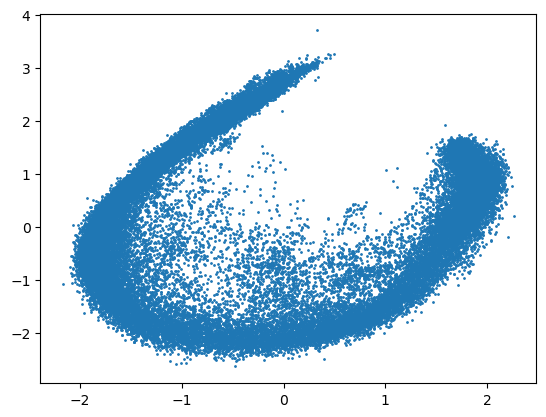

In [6]:
for model_index in [77]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"
    save_dir = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241130/sweep_analysis/plots/{title}".replace(" ", "_")
    os.makedirs(save_dir, exist_ok=True)

    print(title)

    # Split the data
    df_all_train, df_all_test, df_all = split_train_test(df_all)
    df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)


    # Define the comparisons (Multiclass) and obtain coloumns for data
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

import plotly.express as px

df = df_all.copy()
X = df[z_mu_biological_columns].values
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

perturbations = pert_comparisons

# Map perturbations to colors
if perturbations is None:
    perturbations = df['phenotype'].unique()
color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


# Prepare the color array
df['color'] = df['phenotype'].map(color_discrete_map)


df["PCA_1"] = pcs[:,0]
df["PCA_2"] = pcs[:,1]
df["PCA_3"] = pcs[:,2]


pert_df = df[df["phenotype"]=="wt"]


x = pert_df["PCA_1"].to_numpy()
y = pert_df["PCA_2"].to_numpy()
plt.scatter(x, y, s = 1)


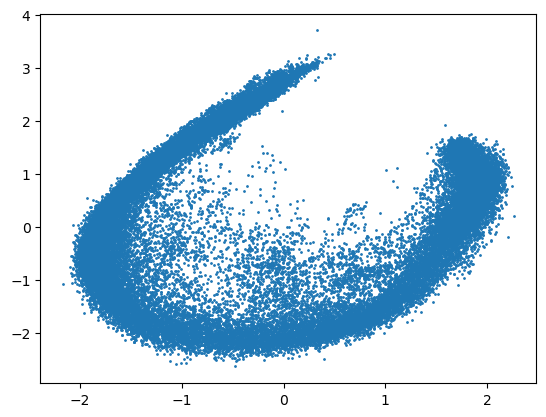

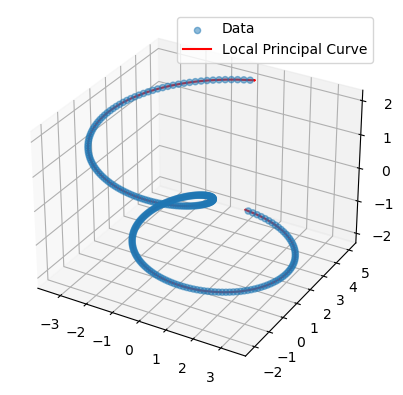

In [52]:
import numpy as np

# Generate synthetic 3D spiral data
np.random.seed(42)
n_points = 300
theta = np.linspace(0, 4 * np.pi, n_points)
z = np.linspace(-2, 2, n_points)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
data = np.vstack([x, y, z]).T

# Create and fit the LPC model
lpc = LocalPrincipalCurve(bandwidth=0.2, max_iter=1000, tol=1e-4, angle_penalty_exp=.1)
paths = lpc.fit(data, start_points=[data[0]])  # Start from a known data point

# Plot the resulting local principal curve
lpc.plot_path_3d(data)

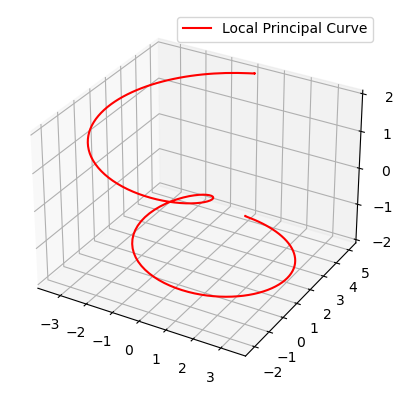

In [53]:
path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()

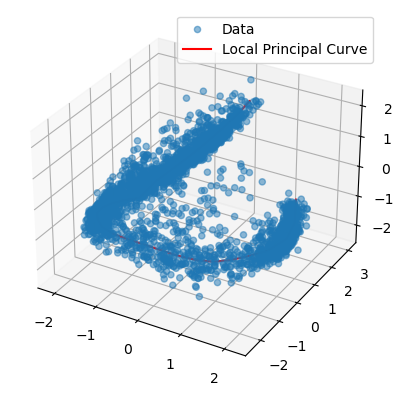

In [ ]:
pert_df = df[df["phenotype"]=="wt"]
pert_3d = pert_df[["PCA_1","PCA_2","PCA_3"]]
# Initialize and fit the Local Principal Curve
pert_3d_subset = pert_3d.sample(frac=0.05, random_state=42)
# Create and fit the LPC model
lpc = LocalPrincipalCurve(bandwidth=0.5, max_iter=1000, tol=1e-3, angle_penalty_exp=2)
paths = lpc.fit(pert_3d_subset, start_points=None)  # Start from a known data point

# Plot the resulting local principal curve
lpc.plot_path_3d(pert_3d_subset)

path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()

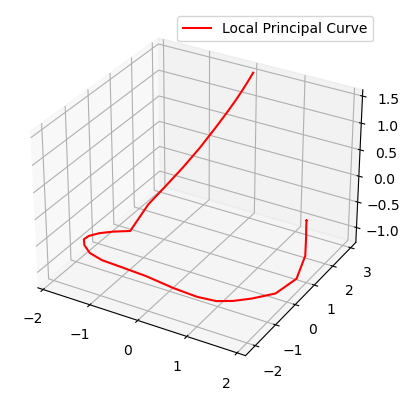

In [152]:
path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()

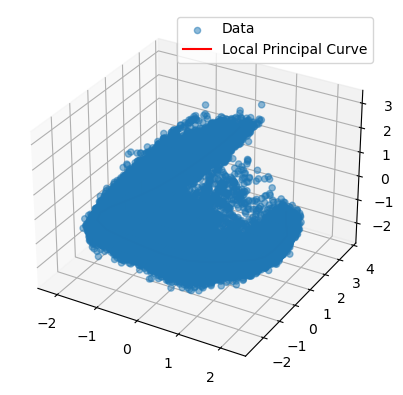

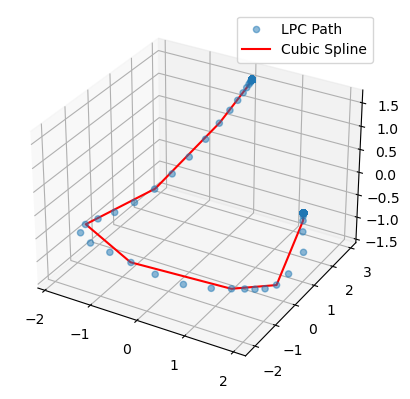

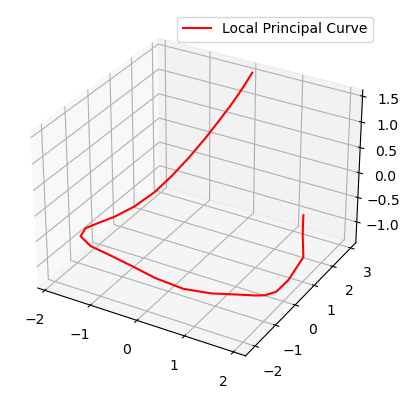

In [8]:
import numpy as np
from scipy.interpolate import CubicSpline

class LocalPrincipalCurve:
    def __init__(self, bandwidth=0.2, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None):
        """
        Initialize the Local Principal Curve solver.

        Parameters:
        - bandwidth: The kernel bandwidth (h). If h is not provided, bandwidth is used as h.
        - max_iter: Maximum number of iterations for forward/backward runs.
        - tol: Tolerance for stopping criterion based on changes in µ_x.
        - angle_penalty_exp: Exponent k used in angle penalization: a_x(i) = |cos(alpha_x(i))|^k.
        - h: Step size t0. If None, set t0 = bandwidth.
        """
        self.bandwidth = bandwidth
        self.h = h if h is not None else self.bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.angle_penalty_exp = angle_penalty_exp
        
        self.initializations = []
        self.paths = []
        self.cubic_splines_eq = []
        self.cubic_splines = []

    def _kernel_weights(self, dataset, x):
        """Compute Gaussian kernel weights w_i = K_h(X_i - x)."""
        dists = np.linalg.norm(dataset - x, axis=1)
        weights = np.exp(- (dists**2) / (2 * self.bandwidth**2))
        w = weights / np.sum(weights)
        return w

    def _local_center_of_mass(self, dataset, x):
        """Compute µ_x, the local center of mass around x."""
        w = self._kernel_weights(dataset, x)
        mu = np.sum(dataset.T * w, axis=1)
        return mu

    def _local_covariance(self, dataset, x, mu):
        """Compute the local covariance matrix Σ_x."""
        w = self._kernel_weights(dataset, x)
        centered = dataset - mu
        cov = np.zeros((dataset.shape[1], dataset.shape[1]))
        for i in range(len(dataset)):
            cov += w[i] * np.outer(centered[i], centered[i])
        return cov

    def _principal_component(self, cov, prev_vec=None):
        """Compute the first local principal component γ_x, with angle penalization."""
        vals, vecs = np.linalg.eig(cov)
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]

        gamma = vecs[:, 0]  # first principal component

        # Sign flipping to maintain direction if prev_vec is given
        if prev_vec is not None and np.linalg.norm(prev_vec) != 0:
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            if cos_alpha < 0:
                gamma = -gamma

            # Angle penalization
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            a_x = (abs(cos_alpha))**self.angle_penalty_exp
            gamma = a_x * gamma + (1 - a_x) * prev_vec
            gamma /= np.linalg.norm(gamma)

        return gamma

    def _forward_run(self, dataset, x_start):
        """Run the algorithm forward from a starting point using the full dataset."""
        x = x_start
        path_x = [x]
        prev_gamma = None

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            # Check convergence
            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _backward_run(self, dataset, x0, gamma0):
        """Run the algorithm backwards from x(0) along -γ_x(0) using the full dataset."""
        x = x0
        path_x = [x]
        prev_gamma = -gamma0

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _find_starting_point(self, dataset, start_point):
        """Ensure starting point is in dataset or choose closest."""
        if start_point is None:
            idx = np.random.choice(len(dataset))
            return dataset[idx], idx
        else:
            diffs = dataset - start_point
            dists = np.linalg.norm(diffs, axis=1)
            min_idx = np.argmin(dists)
            closest_pt = dataset[min_idx]
            if not np.allclose(closest_pt, start_point):
                print(f"Starting point not in dataset. Using closest point: {closest_pt}")
            return closest_pt, min_idx

    def fit(self, dataset, start_points=None):
        """
        Fit LPC on the dataset using possibly multiple starting points.

        Parameters:
        - dataset: n x p array
        - start_points: List of starting points or None.

        Returns:
        - self.paths: List of arrays, each array is a path from one initialization.
        """
        dataset = np.array(dataset)
        self.paths = []
        self.initializations = []

        if start_points is None:
            start_points = [None]

        for sp in start_points:
            x0, _ = self._find_starting_point(dataset, sp)

            forward_path = self._forward_run(dataset, x0)
            if len(forward_path) > 1:
                initial_gamma_direction = (forward_path[1] - forward_path[0]) / self.h
            else:
                initial_gamma_direction = np.zeros(dataset.shape[1])

            if np.linalg.norm(initial_gamma_direction) > 0:
                backward_path = self._backward_run(dataset, x0, initial_gamma_direction)
                full_path = np.vstack([backward_path[::-1], forward_path[1:]])
            else:
                full_path = forward_path

            self.paths.append(full_path)
            self.initializations.append(x0)

        self._fit_cubic_splines_eq()
        self._compute_cubic_spline_points()
        return self.paths

    def _fit_cubic_splines_eq(self):
        """Fit cubic splines (equations) for all paths."""
        self.cubic_splines_eq = []
        for path in self.paths:
            if len(path) < 4:
                self.cubic_splines_eq.append(None)
                continue
            t = np.arange(len(path))
            splines_dict = {}
            for dim in range(path.shape[1]):
                splines_dict[dim] = CubicSpline(t, path[:, dim])
            self.cubic_splines_eq.append(splines_dict)

    def _compute_cubic_spline_points(self, num_points=500):
        """
        Compute parameterized points from each cubic spline equation.
        This fills self.cubic_splines with arrays of evaluated points.
        """
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            path = self.paths[i]
            t_values = np.linspace(0, len(path) - 1, num_points)
            spline_points = self.evaluate_cubic_spline(i, t_values)
            self.cubic_splines.append(spline_points)

    def evaluate_cubic_spline(self, path_idx, t_values):
        """Evaluate the cubic spline equation for a specific path at given parameter values."""
        if path_idx >= len(self.cubic_splines_eq) or self.cubic_splines_eq[path_idx] is None:
            raise ValueError(f"No cubic spline found for path index {path_idx}.")
        spline = self.cubic_splines_eq[path_idx]
        points = np.array([spline[dim](t_values) for dim in range(len(spline))]).T
        return points

    def plot_path_3d(self, dataset, path_idx=0):
        """Plot dataset and one LPC path in 3D for visualization."""
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        dataset = np.array(dataset)
        path = self.paths[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
        ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
        ax.legend()
        plt.show()

    def plot_cubic_spline_3d(self, path_idx, t_values=None, show_path=True):
        """
        Plot the cubic spline for a specific path in 3D.

        Parameters:
        - path_idx: Index of the path to plot the spline for.
        - t_values: Optional parameter values to plot the spline at.
                    If None, t_values will be automatically generated.
        - show_path: Boolean flag to indicate whether to plot the LPC path points.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        if path_idx >= len(self.paths):
            raise IndexError(f"Path index {path_idx} is out of range. Total paths: {len(self.paths)}.")

        path = self.paths[path_idx]
        if t_values is None:
            t_values = np.linspace(0, len(path) - 1, 500)

        spline_points = self.evaluate_cubic_spline(path_idx, t_values)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if show_path:
            ax.scatter(path[:, 0], path[:, 1], path[:, 2], label="LPC Path", alpha=0.5)

        ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2], color="red", label="Cubic Spline")
        ax.legend()
        plt.show()


pert_df = df[df["phenotype"]=="wt"]
pert_3d = pert_df[["PCA_1","PCA_2","PCA_3"]]
# Initialize and fit the Local Principal Curve
pert_3d_subset = pert_3d.sample(frac=0.05, random_state=42)
# Create and fit the LPC model
lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=1000, tol=1e-2, angle_penalty_exp=2)
paths = lpc.fit(pert_3d_subset, start_points=None)  # Start from a known data point

# Plot the resulting local principal curve
lpc.plot_path_3d(pert_3d)

lpc.plot_cubic_spline_3d(0)

path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Define perturbations and assign each a distinct color
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

fig = go.Figure()

for pert in pert_comparisons:
    print(f"processting{pert}" )
    # Filter the DataFrame for the given perturbation
    pert_df = df[df["phenotype"] == pert]
    pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values

    # Downsampling logic as per original pseudo-code
    # (This is optional and can be removed if you want full dataset)
    if pert == "wt":
        pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                          size=int(0.05 * len(pert_3d)), replace=False)]
    else:
        pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                          size=int(0.5 * len(pert_3d)), replace=False)]

    # Fit the Local Principal Curve on the subset
    lpc = LocalPrincipalCurve(bandwidth=.4, max_iter=1000, tol=1e-2, angle_penalty_exp=3)
    paths = lpc.fit(pert_3d_subset, start_points=None)
    
    # Extract the first path (assuming one main path)
    path = paths[0]

    # Evaluate cubic spline points (already computed in lpc.cubic_splines after fit)
    # lpc.cubic_splines[0] gives the parameterized spline points
    spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

    # Add the original points of this perturbation (not just the subset) to the figure
    fig.add_trace(
        go.Scatter3d(
            x=pert_3d[:,0],
            y=pert_3d[:,1],
            z=pert_3d[:,2],
            mode='markers',
            marker=dict(
                size=3,
                opacity=.1  # fully opaque points
            ),
            name=f"{pert} Data",
            showlegend=True,
            marker_color=color_map[pert]
        )
    )

    # Add the cubic spline curve for this perturbation
    if spline_points is not None:
        fig.add_trace(
            go.Scatter3d(
                x=spline_points[:,0],
                y=spline_points[:,1],
                z=spline_points[:,2],
                mode='lines',
                line=dict(width=4),
                name=f"{pert} Cubic Spline",
                showlegend=True,
                line_color=color_map[pert]
            )
        )

# Update layout for a clean look
fig.update_layout(
    scene=dict(
        xaxis_title='PCA_1',
        yaxis_title='PCA_2',
        zaxis_title='PCA_3'
    ),
    title="Local Principal Curves for Multiple Perturbations"
)

# Show the combined 3D interactive figure
fig.show()

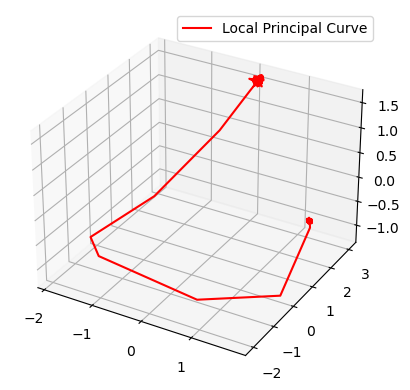

In [187]:
cubic_splines = lpc.cubic_splines
path= cubic_splines[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()

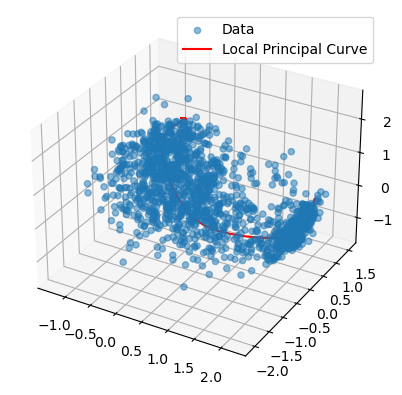

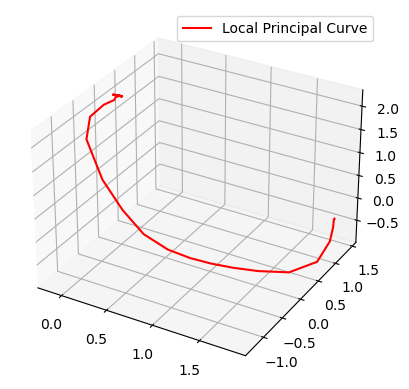

In [ ]:

pert_df = df[df["phenotype"]=="gdf3"]
pert_3d = pert_df[["PCA_1","PCA_2","PCA_3"]]


# Initialize and fit the Local Principal Curve
pert_3d_subset = pert_3d.sample(frac=0.2, random_state=42)
# Create and fit the LPC model
lpc = LocalPrincipalCurve(bandwidth=0.5, max_iter=1000, tol=1e-3, angle_penalty_exp=2)
paths = lpc.fit(pert_3d_subset, start_points=None)  # Start from a known data point

# Plot the resulting local principal curve
lpc.plot_path_3d(pert_3d_subset)

path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()


In [62]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Define perturbations and assign each a distinct color
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

# pert_comparisons = ["wnt-i"]
color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

fig = go.Figure()

for pert in pert_comparisons:
    # Filter the DataFrame for the given perturbation
    print(pert)
    pert_df = df[df["phenotype"] == pert]
    pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values

    avg_early_timepoint = pert_df[
        (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
        (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
    ][["PCA_1", "PCA_2", "PCA_3"]].mean()

    avg_early_timepoint = np.array(avg_early_timepoint)



    # Downsampling logic as per original pseudo-code
    # (This is optional and can be removed if you want full dataset)
    if pert == "wt":
        pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                          size=int(0.05 * len(pert_3d)), replace=False)]
    else:
        pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                          size=int(0.5 * len(pert_3d)), replace=False)]
    print(len(pert_3d_subset))


    # Fit the Local Principal Curve on the subset
    lpc = LocalPrincipalCurve(bandwidth=.8, max_iter=1000, tol=1e-3, angle_penalty_exp=2)
    paths = lpc.fit(pert_3d_subset, start_points= [avg_early_timepoint])
    
    # Extract the first path (assuming one main path)
    path = paths[0]

    # Evaluate cubic spline points (already computed in lpc.cubic_splines after fit)
    # lpc.cubic_splines[0] gives the parameterized spline points
    spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

    # Add the original points of this perturbation (not just the subset) to the figure
    fig.add_trace(
        go.Scatter3d(
            x=pert_3d[:,0],
            y=pert_3d[:,1],
            z=pert_3d[:,2],
            mode='markers',
            marker=dict(
                size=3,
                opacity=.01  # fully opaque points
            ),
            name=f"{pert} Data",
            showlegend=True,
            marker_color=color_map[pert]
        )
    )

    # Add the cubic spline curve for this perturbation
    if spline_points is not None:
        fig.add_trace(
            go.Scatter3d(
                x=spline_points[:,0],
                y=spline_points[:,1],
                z=spline_points[:,2],
                mode='lines',
                line=dict(width=8),
                name=f"{pert} Cubic Spline",
                showlegend=True,
                line_color=color_map[pert]
            )
        )

# Update layout for a clean look
fig.update_layout(
    scene=dict(
        xaxis_title='PCA_1',
        yaxis_title='PCA_2',
        zaxis_title='PCA_3'
    ),
    title="Local Principal Curves for Multiple Perturbations"
)


print("love")

# Show the combined 3D interactive figure


wnt-i
936
Starting point not in dataset. Using closest point: [ 1.95702147  1.03924324 -0.65932128]


tgfb-i
1226
Starting point not in dataset. Using closest point: [ 1.90297498  1.13941387 -0.84501244]
wt
2437
Starting point not in dataset. Using closest point: [ 1.64973178  1.44043901 -0.50209158]
lmx1b
3879
Starting point not in dataset. Using closest point: [ 1.92553144  1.10519427 -0.57109598]
gdf3
3734
Starting point not in dataset. Using closest point: [ 1.66452275  0.98561906 -0.89813748]
love


In [63]:
save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241204"
fig.write_html(os.path.join(save_dir,"mspace_spline6.html"))

In [22]:
save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241204"
fig.write_html(os.path.join(save_dir,"mspace_spline2.html"))

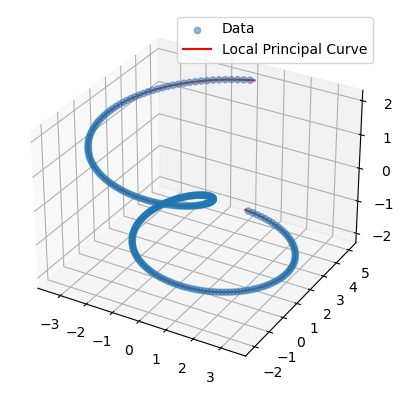

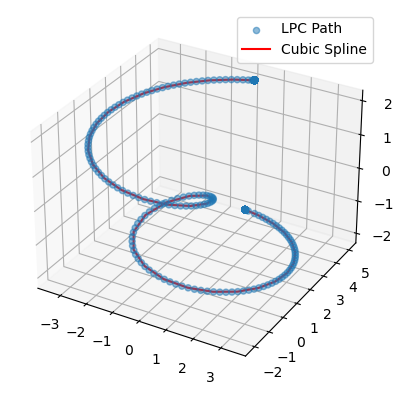

[[ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354  2.00936538]
 [ 0.14492052  5.04137354

In [159]:
import numpy as np

# Generate synthetic 3D spiral data
np.random.seed(42)
n_points = 300
theta = np.linspace(0, 4 * np.pi, n_points)
z = np.linspace(-2, 2, n_points)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
data = np.vstack([x, y, z]).T

# Create and fit the LPC model
lpc = LocalPrincipalCurve(bandwidth=0.2, max_iter=1000, tol=1e-3, angle_penalty_exp=2)
paths = lpc.fit(data, start_points=[data[0]])  # Start from a known data point

# Plot the resulting local principal curve
lpc.plot_path_3d(data)

# Plot the cubic spline for the first path
lpc.plot_cubic_spline_3d(0)

# Evaluate the cubic spline for the first path at specific t values
t_values = np.linspace(0, len(paths[0]) - 1, 100)
spline_points = lpc.evaluate_cubic_spline(0, t_values)
print(spline_points)

Average distance before alignment: 8.508
Average distance after alignment: 8.849


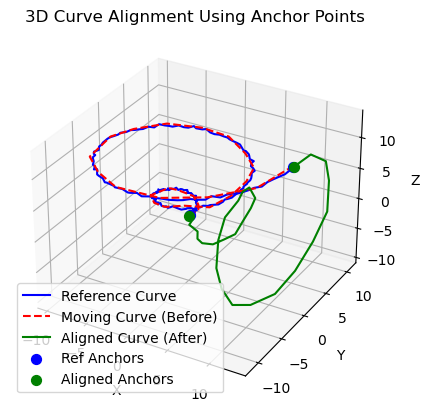

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_spiral(n_points=100, noise=0.0, seed=0):
    """
    Generate a 3D spiral curve.
    """
    np.random.seed(seed)
    t = np.linspace(0, 4*np.pi, n_points)
    x = t * np.cos(t)
    y = t * np.sin(t)
    z = t
    curve = np.vstack((x, y, z)).T
    curve += noise * np.random.randn(*curve.shape)
    return curve

def align_using_anchor_points(curve_ref, curve_move, anchor_ids_ref, anchor_ids_move):
    """
    Compute a rotation and translation that aligns selected anchor points of curve_move
    onto the corresponding anchor points of curve_ref.
    
    Parameters:
    - curve_ref: Reference curve (Nx3).
    - curve_move: Curve to be moved (Nx3).
    - anchor_ids_ref: Indices of anchor points in the reference curve.
    - anchor_ids_move: Indices of anchor points in the moving curve that correspond to anchor_ids_ref.

    Returns:
    - curve_aligned: The transformed version of curve_move after alignment.
    - R: The rotation matrix (3x3).
    - t: The translation vector (3,).
    """
    # Extract anchor points
    A = curve_ref[anchor_ids_ref]   # shape (M,3)
    B = curve_move[anchor_ids_move] # shape (M,3)

    # Compute centroids of the anchor points
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Center the anchor points around their centroids
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Compute optimal rotation using Singular Value Decomposition (SVD)
    # This is the Kabsch algorithm for finding the best rotation
    H = B_centered.T @ A_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Ensure we have a proper rotation (no reflection)
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T

    # Compute translation
    t = centroid_A - R @ centroid_B

    # Apply transformation to the entire moving curve
    curve_aligned = (curve_move - centroid_B) @ R.T + centroid_A

    return curve_aligned, R, t

def measure_alignment(curve1, curve2):
    """
    Measure how well curve2 aligns to curve1 by computing the mean distance
    between corresponding points. This is a naive metric, assuming curves
    are parameterized similarly.
    """
    # Ensure same number of points by interpolation or just indexing
    # For simplicity, assume same length
    if len(curve1) != len(curve2):
        # Simple handling: truncate to min length
        min_len = min(len(curve1), len(curve2))
        curve1 = curve1[:min_len]
        curve2 = curve2[:min_len]

    dists = np.linalg.norm(curve1 - curve2, axis=1)
    return np.mean(dists)

# Generate two curves
curve_ref = generate_spiral(n_points=200, noise=0.1, seed=0)
curve_move = generate_spiral(n_points=30, noise=.2, seed=1)

# Let's say we pick two anchor points: start (0) and end (-1) of the curve
anchor_ids_ref = [0, -1]
anchor_ids_move = [0, -1]

# Align curve_move to curve_ref using these anchor points
curve_aligned, R, t = align_using_anchor_points(curve_ref, curve_move, anchor_ids_ref, anchor_ids_move)

# Measure alignment quality
original_dist = measure_alignment(curve_ref, curve_move)
aligned_dist = measure_alignment(curve_ref, curve_aligned)

print(f"Average distance before alignment: {original_dist:.3f}")
print(f"Average distance after alignment: {aligned_dist:.3f}")

# Plot the curves
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Reference curve in blue
ax.plot(curve_ref[:,0], curve_ref[:,1], curve_ref[:,2], 'b-', label='Reference Curve')

# Original moving curve in red
ax.plot(curve_move[:,0], curve_move[:,1], curve_move[:,2], 'r--', label='Moving Curve (Before)')

# Aligned moving curve in green
ax.plot(curve_aligned[:,0], curve_aligned[:,1], curve_aligned[:,2], 'g-', label='Aligned Curve (After)')

# Highlight anchor points
ax.scatter(curve_ref[anchor_ids_ref,0], curve_ref[anchor_ids_ref,1], curve_ref[anchor_ids_ref,2],
           color='blue', s=50, label='Ref Anchors', depthshade=False)

ax.scatter(curve_aligned[anchor_ids_move,0], curve_aligned[anchor_ids_move,1], curve_aligned[anchor_ids_move,2],
           color='green', s=50, label='Aligned Anchors', depthshade=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title("3D Curve Alignment Using Anchor Points")
plt.show()